In [1]:
import pandas as pd
import networkx as nx
from collections import Counter

import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('./topics/df_topic_OBE.csv')

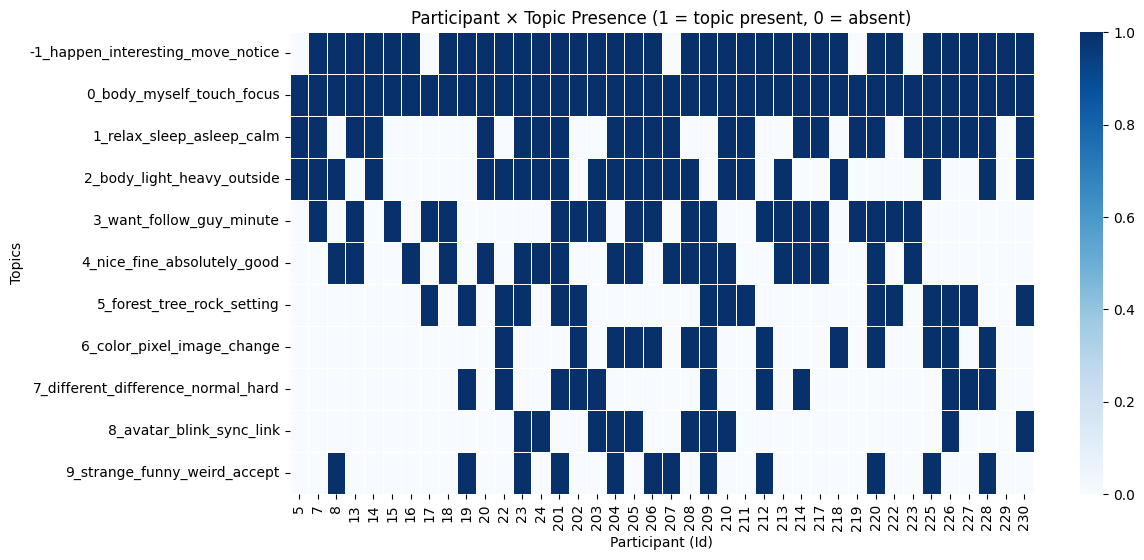

In [12]:
# 1. Count occurrences of each topic by participant
participant_topic_counts = (
    df.groupby(["Id", "one_topic_name"])["Content"]
    .size()
    .reset_index(name="Count")
)

# 2. Convert any Count > 0 to presence = 1
participant_topic_counts["Presence"] = (participant_topic_counts["Count"] > 0).astype(int)

# 3. Pivot to create a presence matrix
presence_matrix = participant_topic_counts.pivot(
    index="one_topic_name", 
    columns="Id", 
    values="Presence"
).fillna(0)

# 4. Visualize as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    presence_matrix, 
    cmap="Blues", 
    linewidths=.5,
)
plt.title("Participant × Topic Presence (1 = topic present, 0 = absent)")
plt.ylabel("Topics")
plt.xlabel("Participant (Id)")
plt.show()

<Axes: xlabel='File Name'>

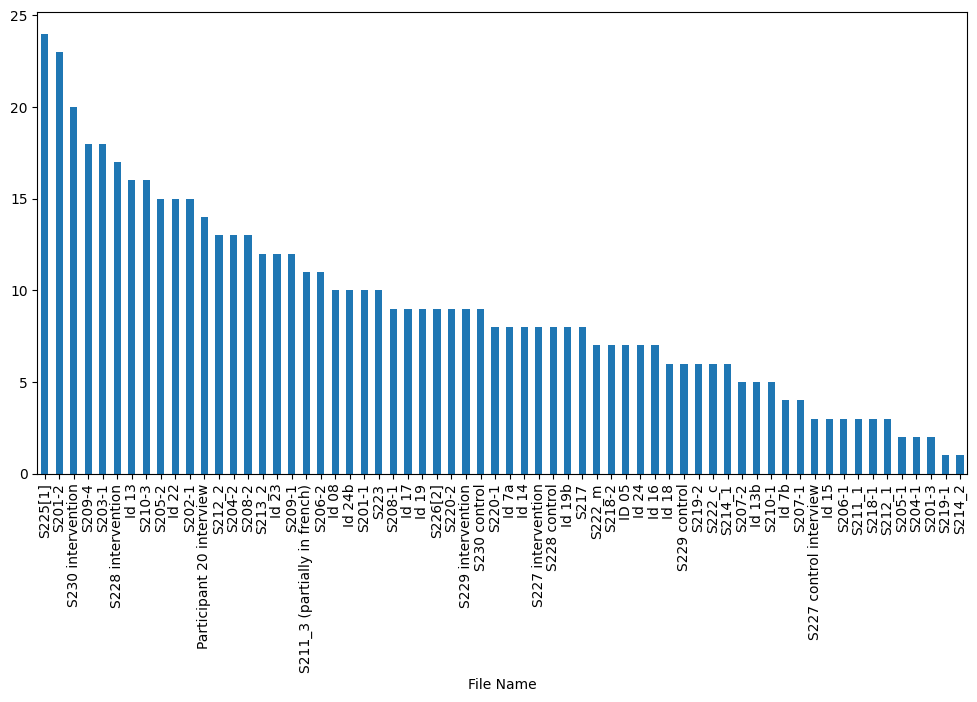

In [13]:
# make a plot showing the number of turn by file name
df["File Name"].value_counts().plot(kind="bar", figsize=(12, 6))

# Networks

In [14]:
def build_network_from_interviews(df_interviews, include_self_loops=True):
    """
    Build a directed network graph from interviews, aggregating topic transitions across all interviews.
    
    Parameters:
    - df_interviews (pd.DataFrame): DataFrame containing interview data with columns 'File Name', 'turn_index', and 'one_topic_name'.
    - include_self_loops (bool): Whether to include self-loops in the graph.
    
    Returns:
    - G (nx.DiGraph): Directed graph with aggregated topic transitions and edge weights and node attributes (topic counts).
    """
    # Initialize directed graph
    G = nx.DiGraph()

    # Count topic occurrences (total mentions) across all interviews
    occurrence_counts = Counter(df_interviews["one_topic_name"])

    # Count topic appearances (number of files where a topic appears)
    appearance_counts = (
        df_interviews.groupby("one_topic_name")["File Name"].nunique().to_dict()
    )

    # Add nodes with both counts as attributes
    for topic in occurrence_counts:
        G.add_node(
            topic,
            occurrence=occurrence_counts[topic],
            appearance=appearance_counts.get(topic, 0),
        )

    # Group by interview ID to process each interview path
    grouped = df_interviews.sort_values("turn_index").groupby("File Name")

    for interview_id, group in grouped:
        # Get the ordered sequence of topics for the interview
        topics = group["one_topic_name"].tolist()

        # Add edges for consecutive topics in the sequence
        for i in range(len(topics) - 1):
            u = topics[i]
            v = topics[i + 1]
            if u != v or include_self_loops:
                # Add or update edge with weight
                if G.has_edge(u, v):
                    G[u][v]["weight"] += 1
                else:
                    G.add_edge(u, v, weight=1)

    return G

In [15]:
def plot_topic_transition_network(
    G,
    title="Topic Transition Network",
    show_edge_labels=True,
    save_path=None,
    background_color="white",
    size_by="occurrence",  # Options: 'occurrence' or 'appearance'
):
    """
    Plot the directed topic transition network with numeric labels, enhanced arrow visibility, and adjusted edge margins.
    
    Parameters:
        G (Graph): The directed graph to plot (topics as nodes, transitions as edges).
        title (str): The title of the plot.
        show_edge_labels (bool): Whether to show edge weight labels.
        save_path (str, optional): Path to save the plot as an image file. If None, the plot is not saved.
        background_color (str): Background color of the plot ('white' or 'transparent').
        size_by (str): Criterion for node size ('occurrence' or 'appearance').
    """

    # Determine the background color
    facecolor = "none" if background_color == "transparent" else background_color

    # Initialize the plot
    fig = plt.figure(figsize=(15, 10), dpi=400, facecolor=facecolor)
    pos = nx.spring_layout(G, seed=42, k=0.5, scale=3)

    # Assign a unique color to each node using a default colormap
    num_nodes = len(G.nodes())
    cmap = plt.get_cmap("tab10", num_nodes)  # Default colormap with distinct colors
    default_palette = {node: mcolors.to_hex(cmap(i)) for i, node in enumerate(G.nodes())}

    # Node sizes based on the selected criterion
    if size_by not in {"occurrence", "appearance"}:
        raise ValueError("size_by must be either 'occurrence' or 'appearance'.")

    node_sizes = [
        800 + G.nodes[node].get(size_by, 0) * 300 for node in G.nodes()
    ]

    node_sizes_dict = {node: size for node, size in zip(G.nodes(), node_sizes)}

    # Node colors
    node_colors = [default_palette[node] for node in G.nodes()]

    # Extract numeric IDs from node names (e.g., "2_see_myself_awake_love" -> "2")
    numeric_labels = {node: node.split("_")[0] for node in G.nodes()}

    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos, node_size=node_sizes, node_color=node_colors, edgecolors="white", linewidths=1.5
    )
    
    # Draw numeric node labels
    nx.draw_networkx_labels(G, pos, labels=numeric_labels, font_size=16, font_color="white")

    # Draw edges with enhanced arrows and adjusted margins
    all_weights = [G[u][v]["weight"] for u, v in G.edges()]
    max_weight = max(all_weights) if all_weights else 1

    for u, v, data in G.edges(data=True):
        weight = data["weight"]
        edge_width = weight / max_weight * 3
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            width=edge_width,
            arrowstyle="-|>",  # Arrow style for sharp arrowheads
            arrowsize=20,  # Increased arrow size for visibility
            edge_color="#2C3E50",  # Dark edge color
            alpha=0.8,  # Slight transparency for polished look
            min_source_margin=math.sqrt(node_sizes_dict[u] / math.pi),  # Adjust for source node size
            min_target_margin=math.sqrt(node_sizes_dict[v] / math.pi),  # Adjust for target node size
        )

    # Draw edge labels if enabled
    if show_edge_labels:
        edge_labels = {(u, v): f"{data['weight']}" for u, v, data in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Add legend with full topic names
    legend_labels = {numeric_labels[node]: node for node in G.nodes()}
    handles = [
        plt.Line2D([0], [0], marker="o", color=default_palette[node], linestyle="", markersize=10)
        for node in G.nodes()
    ]
    labels = [f"{value}" for key, value in legend_labels.items()]
    plt.legend(
        handles, labels, title="Topics", loc="best", fontsize=14, title_fontsize=16
    )

    # Final plot adjustments
    plt.title(title, fontsize=20, color="#3b3b3b")
    plt.axis("off")
    plt.tight_layout()

    # Save plot if requested
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=1000, facecolor=facecolor)

    plt.show()

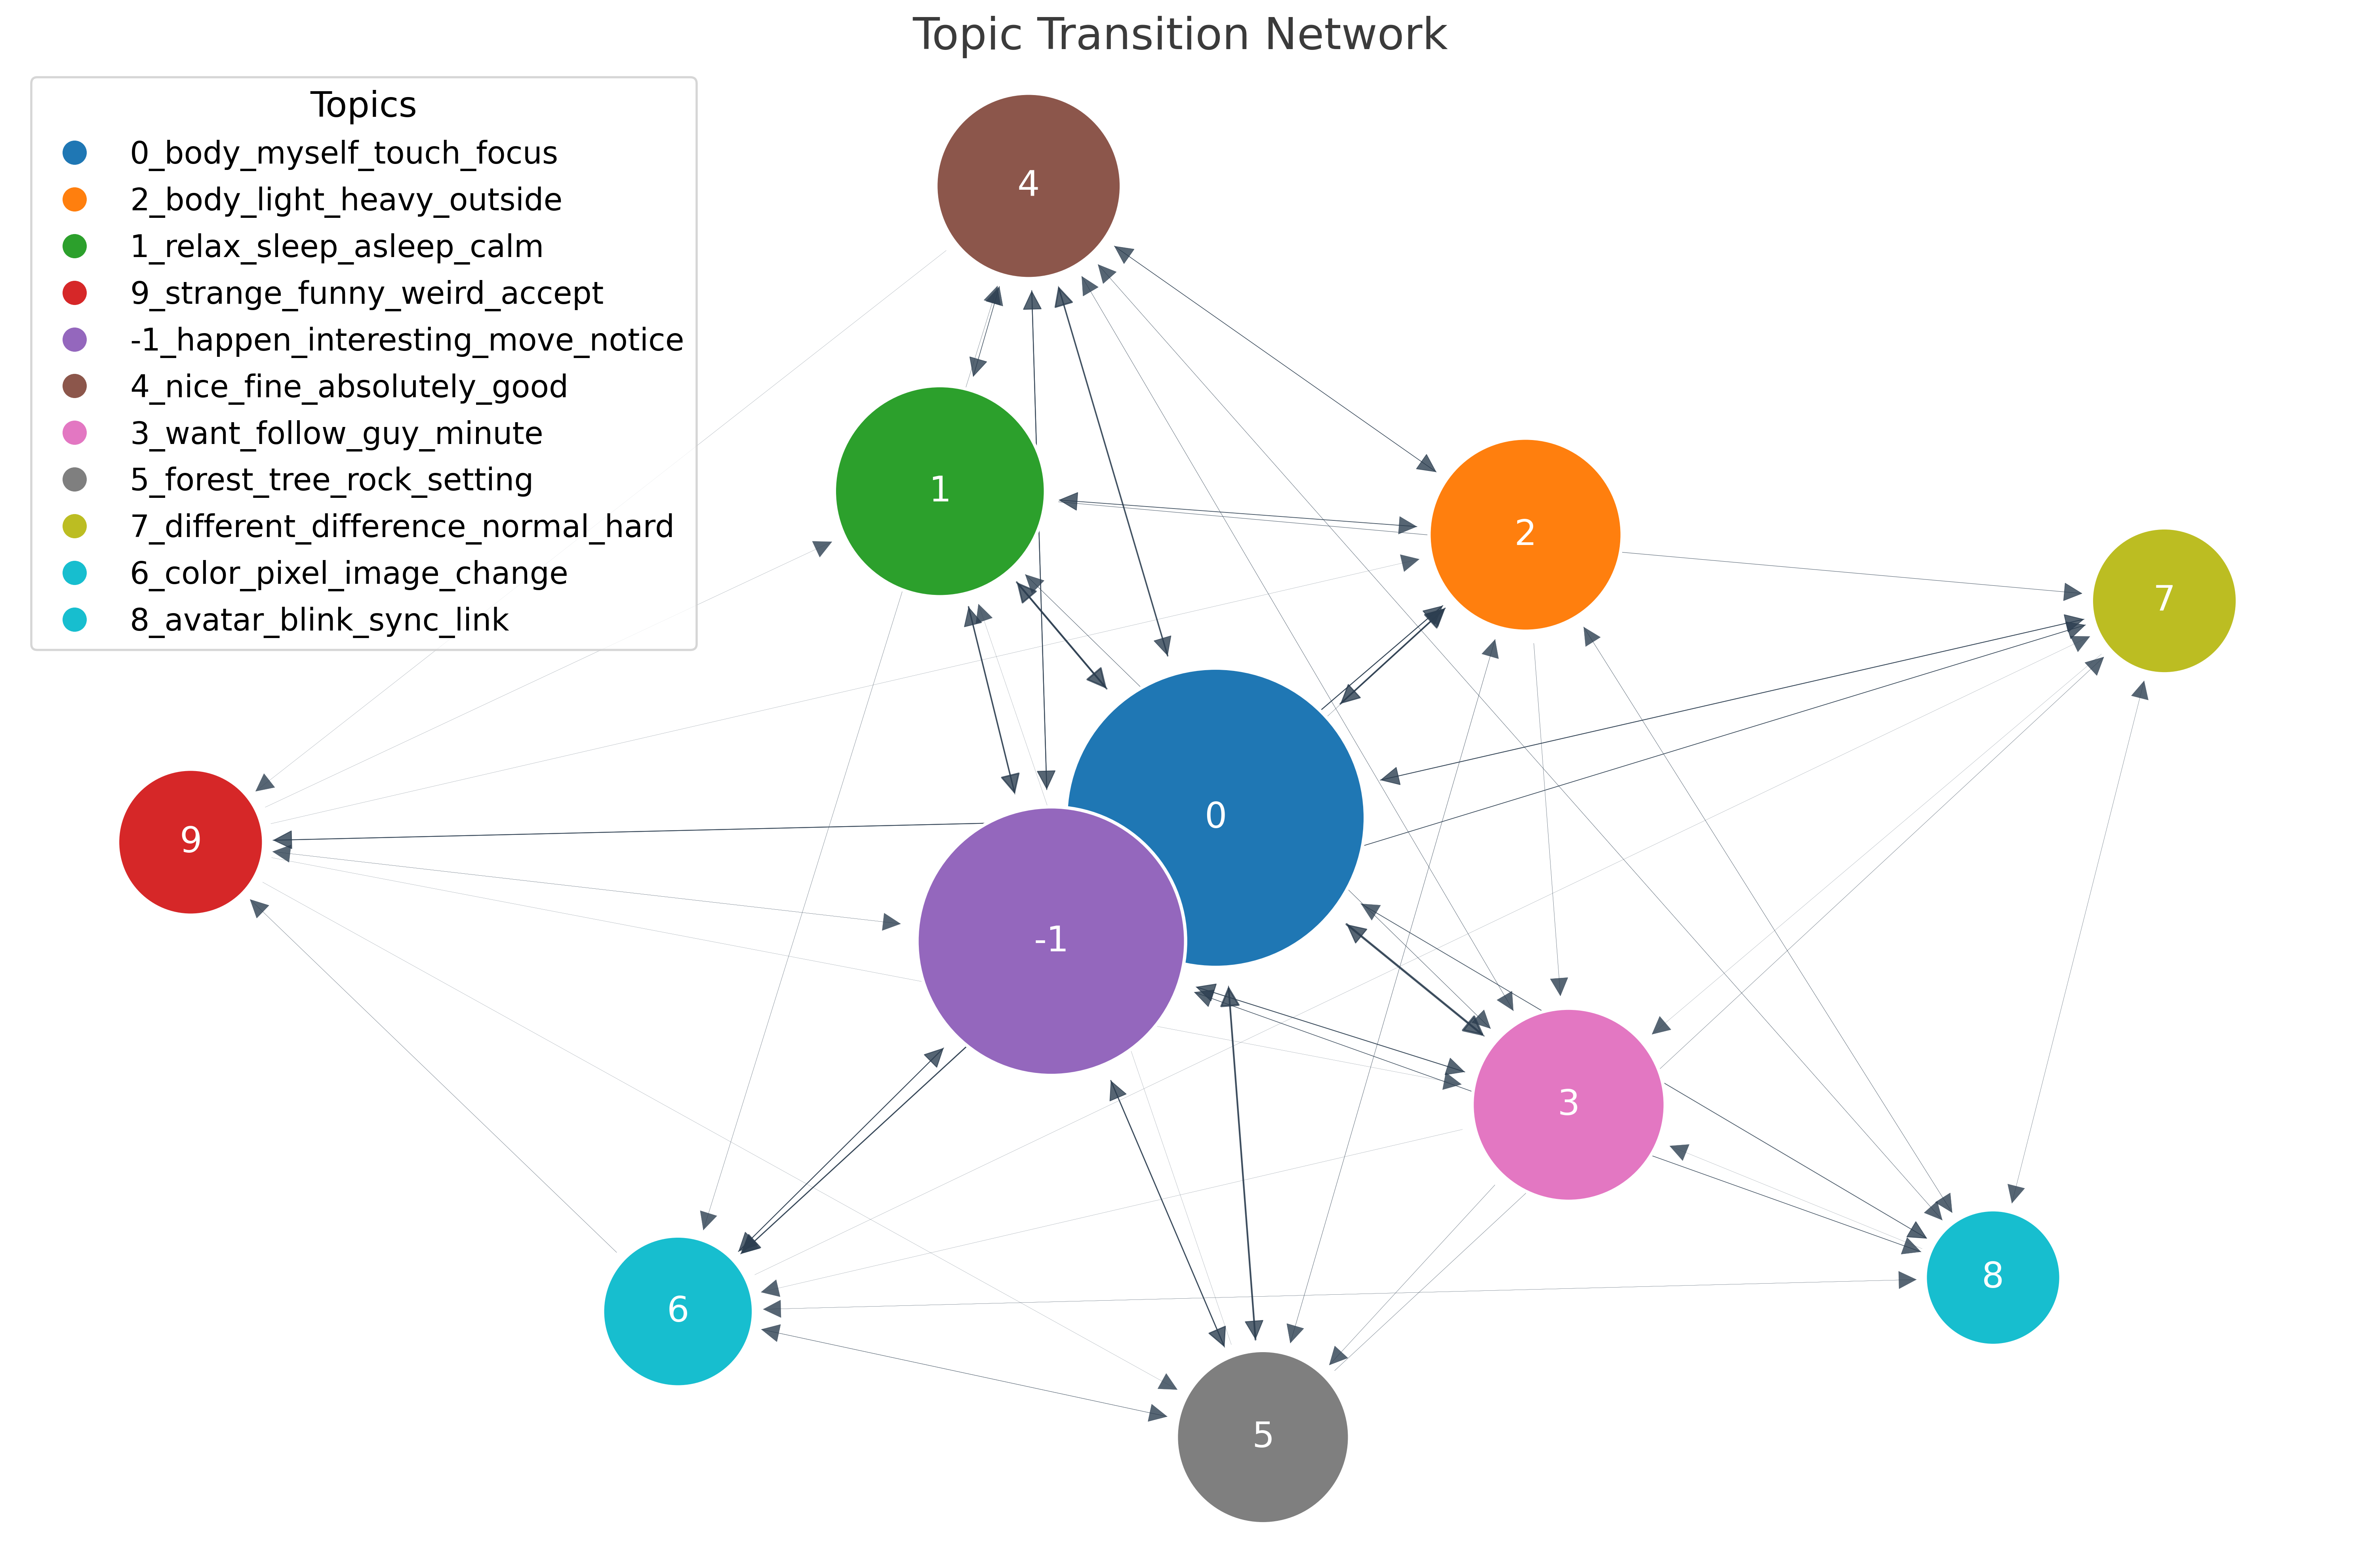

In [16]:
# Build the network graph
G = build_network_from_interviews(df, include_self_loops=False)

plot_topic_transition_network(G, show_edge_labels=False, size_by="appearance") # appearance

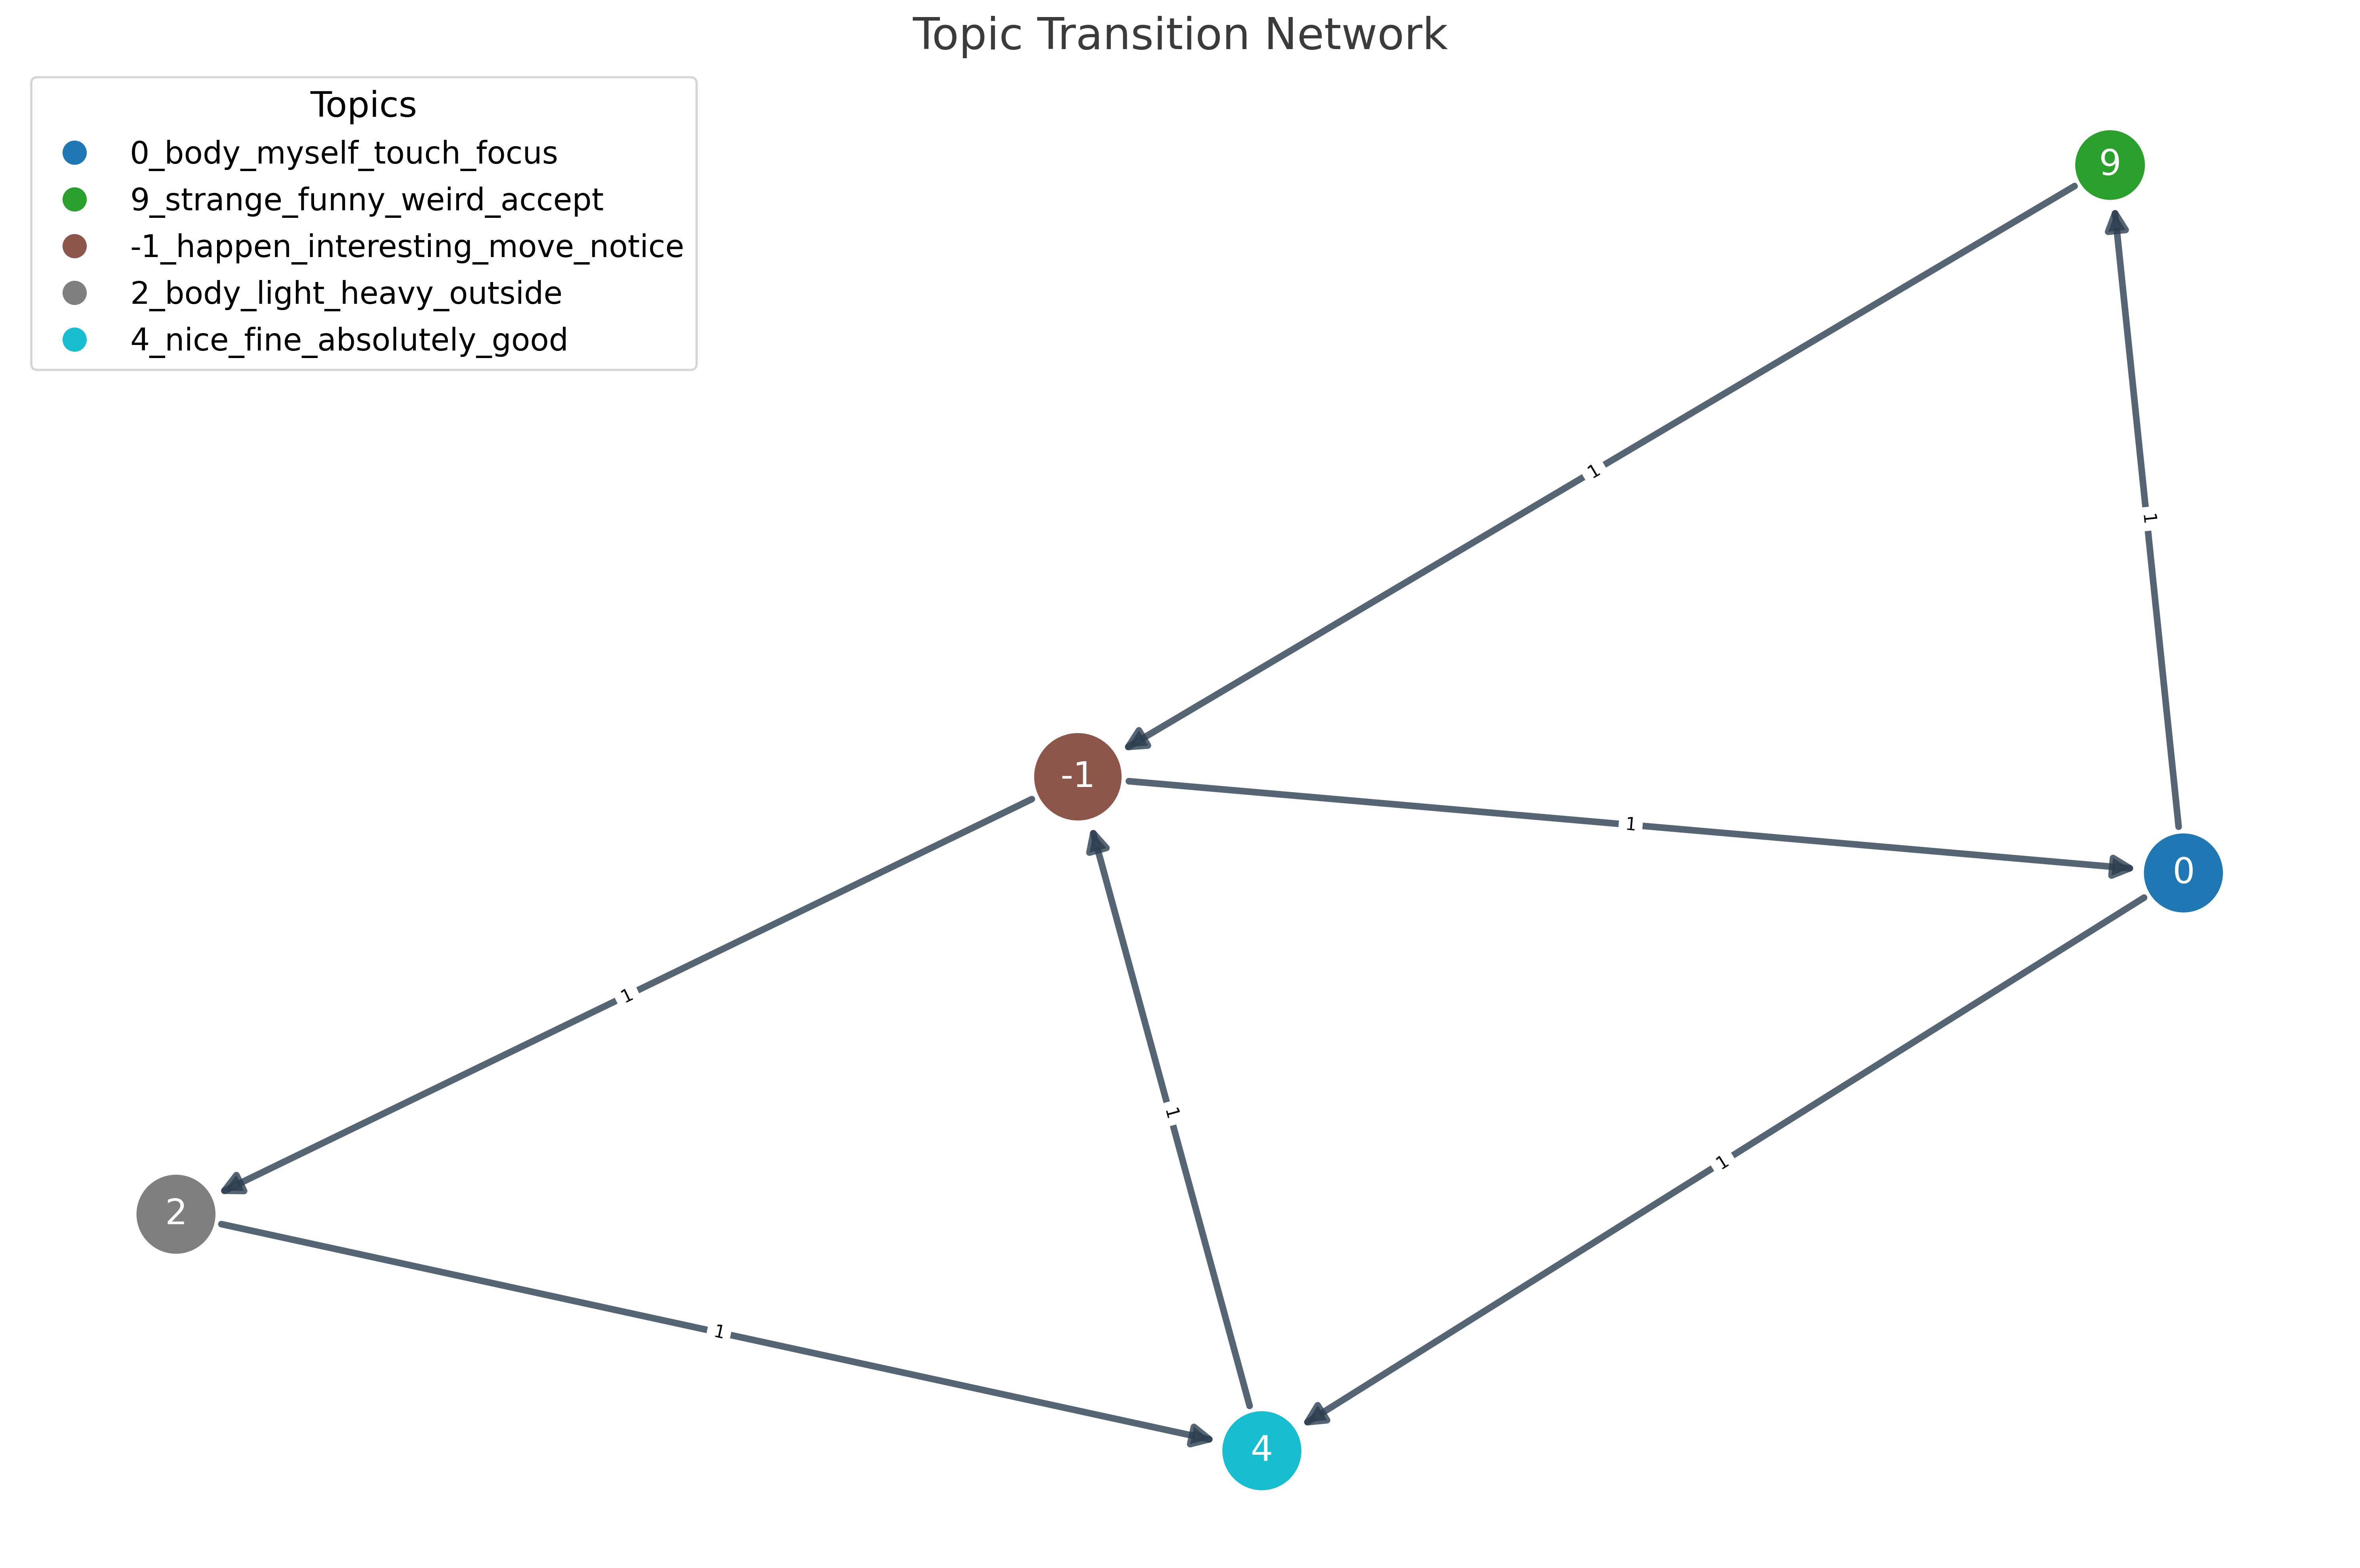

In [18]:
# Build the network graph
G_single = build_network_from_interviews(df[df["File Name"] == "Id 08"], include_self_loops=False)

plot_topic_transition_network(G_single, show_edge_labels=True, size_by="occurrence")